# Sheet 5

## 1 
(a)

$\frac{\partial\sigma(x))}{\partial x} =\frac{\partial}{\partial x} \frac{1}{1+\exp(-x)} = \frac{-(-\exp(-x))}{(1+\exp(-x))^2} =  \exp(-x)\sigma(x)^2$

(b) 

Consider 
$2\sigma(2x) -1 = 2\frac{1}{1+\exp(-2x)} -1 = 2\frac{\exp(x)}{\exp(x) + \exp(-x)} -1 = \frac{2\exp(x) -\exp(x) - \exp(-x)}{\exp(x) + \exp(-x)} = \tanh(x).$

(c) 

$\boldsymbol{a} = (1,1)^{\mathrm{T}}$,
$\boldsymbol{c} = (2,2)^{\mathrm{T}}$,
$\boldsymbol{d} = (1,2)^{\mathrm{T}}$,
$\boldsymbol{f} = (2,3)^{\mathrm{T}}$,

Consider $\boldsymbol{w} = (4,-3)$, $b = 0$:
$$\sigma(\boldsymbol{a}; \boldsymbol{w}, b) = \sigma(1) > 0.5 $$
$$\sigma(\boldsymbol{c}; \boldsymbol{w}, b) = \sigma(2) > 0.5 $$
$$\sigma(\boldsymbol{d}; \boldsymbol{w}, b) = \sigma(-2) < 0.5 $$
$$\sigma(\boldsymbol{f}; \boldsymbol{w}, b) = \sigma(-1) < 0.5 $$

In [2]:
import os
import pandas as pd
from sklearn.linear_model import LogisticRegression
import numpy as np
from matplotlib import pyplot as plt


## 2 Logistic regression: an LLM lie detector

Download the data from https://heibox.uni-heidelberg.de/f/38bd3f2a9b7944248cc2/   
Unzip it and place the lie_detection folder in the folder named `data` to get the following structure:
"data/lie_detection/datasets" and "data/lie_detection/acts".

This is how you can load a dataset of LLM activations. Use a new Datamanager if you want to have a new dataset. Use the same data manager if you want to combine datasets.

In [4]:
from lie_detection_utils import DataManager

path_to_datasets = "data/datasets"
path_to_acts = "data/acts"

# check if the datasets and activations are available
assert os.path.exists(path_to_datasets), "The path to the datasets does not exist."
assert os.path.exists(path_to_acts), "The path to the activations does not exist."

# these are the different datasets containing true and false factual statements about different topics
dataset_names = ["cities", "neg_cities", "sp_en_trans", "neg_sp_en_trans"]
dataset_name = dataset_names[0] # choose some dataset from the above datasets, index "0" loads the "cities" dataset for example

# the dataloader automatically loads the training data for us
dm = DataManager()
dm.add_dataset(dataset_name, "Llama3", "8B", "chat", layer=12, split=0.8, center=False,
                device='cpu', path_to_datasets=path_to_datasets, path_to_acts=path_to_acts)
acts_train, labels_train = dm.get('train') # train set
acts_test, labels_test = dm.get('val')
print(acts_train.shape, labels_train.shape)

torch.Size([1196, 4096]) torch.Size([1196])


/home/jona/Code/Python/Machine Learning/mlph_w24/mlph_w24-2/sheet05/lie_detection_utils.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  acts = [t.load(os.path.join(dire

In [5]:
# have a look at the statements that were fed to the LLM to produce the activations:
df = pd.read_csv(f"{path_to_datasets}/{dataset_name}.csv")
print(df.head(10))

                                        statement  label       city  \
0             The city of Krasnodar is in Russia.      1  Krasnodar   
1       The city of Krasnodar is in South Africa.      0  Krasnodar   
2                  The city of Lodz is in Poland.      1       Lodz   
3  The city of Lodz is in the Dominican Republic.      0       Lodz   
4            The city of Maracay is in Venezuela.      1    Maracay   
5                The city of Maracay is in China.      0    Maracay   
6              The city of Baku is in Azerbaijan.      1       Baku   
7                 The city of Baku is in Ukraine.      0       Baku   
8                  The city of Baoji is in China.      1      Baoji   
9              The city of Baoji is in Guatemala.      0      Baoji   

                  country correct_country  
0                  Russia          Russia  
1            South Africa          Russia  
2                  Poland          Poland  
3  the Dominican Republic          Poland 

(a)

In [6]:

for dataset_name in dataset_names:
    dm = DataManager()
    dm.add_dataset(dataset_name, "Llama3", "8B", "chat", layer=12, split=0.8, center=False,
                    device='cpu', path_to_datasets=path_to_datasets, path_to_acts=path_to_acts)
    acts_train, labels_train = dm.get('train') # train set
    print(acts_train.mean(), acts_train.std())
    acts_test, labels_test = dm.get('val')
    print(acts_train.shape, labels_train.shape)
    
    logreg = LogisticRegression(n_jobs=1, C=1e6, random_state=0)
    
    logreg.fit(acts_train, labels_train)
    assert logreg.n_features_in_ == 4096
    
    print("score", dataset_name, logreg.score(acts_test, labels_test), np.max(logreg.coef_))

/home/jona/Code/Python/Machine Learning/mlph_w24/mlph_w24-2/sheet05/lie_detection_utils.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  acts = [t.load(os.path.join(dire

tensor(0.0002) tensor(0.0984)
torch.Size([1196, 4096]) torch.Size([1196])
score cities 1.0 1.080491910664644
tensor(-0.0002) tensor(0.1107)
torch.Size([1196, 4096]) torch.Size([1196])
score neg_cities 1.0 0.34295041814808996


/home/jona/Code/Python/Machine Learning/mlph_w24/mlph_w24-2/sheet05/lie_detection_utils.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  acts = [t.load(os.path.join(dire

tensor(-0.0027) tensor(0.1097)
torch.Size([283, 4096]) torch.Size([283])
score sp_en_trans 1.0 0.41178237723791977
tensor(-0.0009) tensor(0.1103)
torch.Size([283, 4096]) torch.Size([283])
score neg_sp_en_trans 1.0 0.44578610734982427


If our inputs were linearly separable, we would expect at least one very large value in the weights vectors $\boldsymbol{w}$, $y = \sigma(\boldsymbol{w}\cdot\boldsymbol{x} + b)$, because then the sigmoid turns into a step function along that dimension of data. Howver, the maximum is on the order of unity for all datasets, suggesting that in our chosen representation the classes are not linearly separable and have some overlap. 

(b)

In [7]:
from sklearn.metrics import ConfusionMatrixDisplay

# Plot of accuracy when train and test data come from different datasets, without regularization

scores = []
for train_set_name in dataset_names:
    for test_set_name in dataset_names:
        
        dm1 = DataManager()
        dm1.add_dataset(train_set_name, "Llama3", "8B", "chat", layer=12, split=0.8, center=False,
                        device='cpu', path_to_datasets=path_to_datasets, path_to_acts=path_to_acts)
        acts_train, labels_train = dm1.get('train') # train set

        
        dm2 = DataManager()
        dm2.add_dataset(test_set_name, "Llama3", "8B", "chat", layer=12, split=0.8, center=False,
                        device='cpu', path_to_datasets=path_to_datasets, path_to_acts=path_to_acts)
        acts_test, labels_test = dm2.get('val')
        
        logreg = LogisticRegression(n_jobs=10, C=1e6, random_state=0)
        
        logreg.fit(acts_train, labels_train)
        score = logreg.score(acts_test, labels_test)
        print("score", train_set_name, test_set_name, score)
        scores.append(logreg.score(acts_test, labels_test))


/home/jona/Code/Python/Machine Learning/mlph_w24/mlph_w24-2/sheet05/lie_detection_utils.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  acts = [t.load(os.path.join(dire

score cities cities 1.0


/home/jona/Code/Python/Machine Learning/mlph_w24/mlph_w24-2/sheet05/lie_detection_utils.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  acts = [t.load(os.path.join(dire

score cities neg_cities 0.49666666666666665


/home/jona/Code/Python/Machine Learning/mlph_w24/mlph_w24-2/sheet05/lie_detection_utils.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  acts = [t.load(os.path.join(dire

score cities sp_en_trans 0.6338028169014085


/home/jona/Code/Python/Machine Learning/mlph_w24/mlph_w24-2/sheet05/lie_detection_utils.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  acts = [t.load(os.path.join(dire

score cities neg_sp_en_trans 0.5633802816901409


/home/jona/Code/Python/Machine Learning/mlph_w24/mlph_w24-2/sheet05/lie_detection_utils.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  acts = [t.load(os.path.join(dire

score neg_cities cities 0.7133333333333334


/home/jona/Code/Python/Machine Learning/mlph_w24/mlph_w24-2/sheet05/lie_detection_utils.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  acts = [t.load(os.path.join(dire

score neg_cities neg_cities 1.0


/home/jona/Code/Python/Machine Learning/mlph_w24/mlph_w24-2/sheet05/lie_detection_utils.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  acts = [t.load(os.path.join(dire

score neg_cities sp_en_trans 0.971830985915493


/home/jona/Code/Python/Machine Learning/mlph_w24/mlph_w24-2/sheet05/lie_detection_utils.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  acts = [t.load(os.path.join(dire

score neg_cities neg_sp_en_trans 1.0


/home/jona/Code/Python/Machine Learning/mlph_w24/mlph_w24-2/sheet05/lie_detection_utils.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  acts = [t.load(os.path.join(dire

score sp_en_trans cities 0.94


/home/jona/Code/Python/Machine Learning/mlph_w24/mlph_w24-2/sheet05/lie_detection_utils.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  acts = [t.load(os.path.join(dire

score sp_en_trans neg_cities 0.9866666666666667


/home/jona/Code/Python/Machine Learning/mlph_w24/mlph_w24-2/sheet05/lie_detection_utils.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  acts = [t.load(os.path.join(dire

score sp_en_trans sp_en_trans 1.0


/home/jona/Code/Python/Machine Learning/mlph_w24/mlph_w24-2/sheet05/lie_detection_utils.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  acts = [t.load(os.path.join(dire

score sp_en_trans neg_sp_en_trans 0.4507042253521127


/home/jona/Code/Python/Machine Learning/mlph_w24/mlph_w24-2/sheet05/lie_detection_utils.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  acts = [t.load(os.path.join(dire

score neg_sp_en_trans cities 0.49666666666666665


/home/jona/Code/Python/Machine Learning/mlph_w24/mlph_w24-2/sheet05/lie_detection_utils.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  acts = [t.load(os.path.join(dire

score neg_sp_en_trans neg_cities 0.9866666666666667


/home/jona/Code/Python/Machine Learning/mlph_w24/mlph_w24-2/sheet05/lie_detection_utils.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  acts = [t.load(os.path.join(dire

score neg_sp_en_trans sp_en_trans 0.4507042253521127


/home/jona/Code/Python/Machine Learning/mlph_w24/mlph_w24-2/sheet05/lie_detection_utils.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  acts = [t.load(os.path.join(dire

score neg_sp_en_trans neg_sp_en_trans 1.0


Text(0.5, 1.0, ' ood accuracy w/ unregularized log reg')

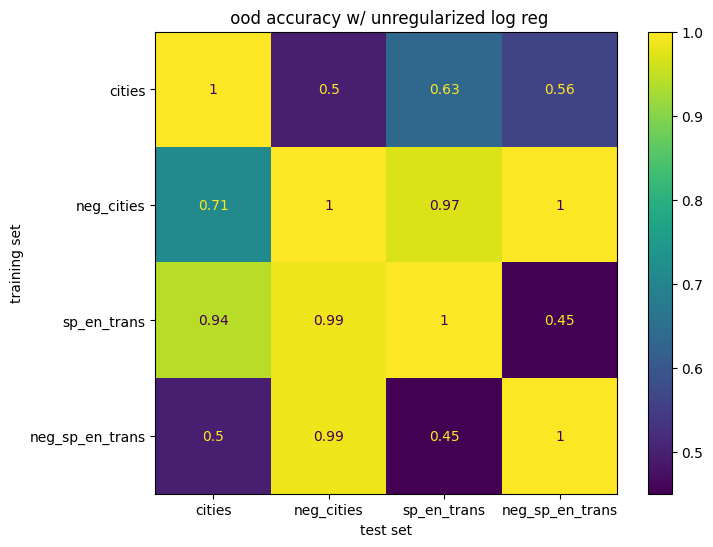

In [8]:
fig, ax = plt.subplots(1,1,figsize=(8,6))
cm = ConfusionMatrixDisplay(np.reshape(scores, (4,4)), display_labels = dataset_names)

cm.plot(ax=ax)
ax.set_xlabel("test set")
ax.set_ylabel("training set")
ax.set_title(" ood accuracy w/ unregularized log reg")

In [9]:
from sklearn.metrics import ConfusionMatrixDisplay

# Plot of accuracy when train and test data come from different datasets, without regularization

scores = []
for train_set_name in dataset_names:
    for test_set_name in dataset_names:
        
        dm1 = DataManager()
        dm1.add_dataset(train_set_name, "Llama3", "8B", "chat", layer=12, split=0.8, center=False,
                        device='cpu', path_to_datasets=path_to_datasets, path_to_acts=path_to_acts)
        acts_train, labels_train = dm1.get('train') # train set

        
        dm2 = DataManager()
        dm2.add_dataset(test_set_name, "Llama3", "8B", "chat", layer=12, split=0.8, center=False,
                        device='cpu', path_to_datasets=path_to_datasets, path_to_acts=path_to_acts)
        acts_test, labels_test = dm2.get('val')
        
        logreg = LogisticRegression(n_jobs=10, C=1, random_state=0)
        
        logreg.fit(acts_train, labels_train)
        score = logreg.score(acts_test, labels_test)
#        print("score", train_set_name, test_set_name, score)
        scores.append(logreg.score(acts_test, labels_test))


/home/jona/Code/Python/Machine Learning/mlph_w24/mlph_w24-2/sheet05/lie_detection_utils.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  acts = [t.load(os.path.join(dire

Text(0.5, 1.0, ' ood accuracy w/ regularized log reg')

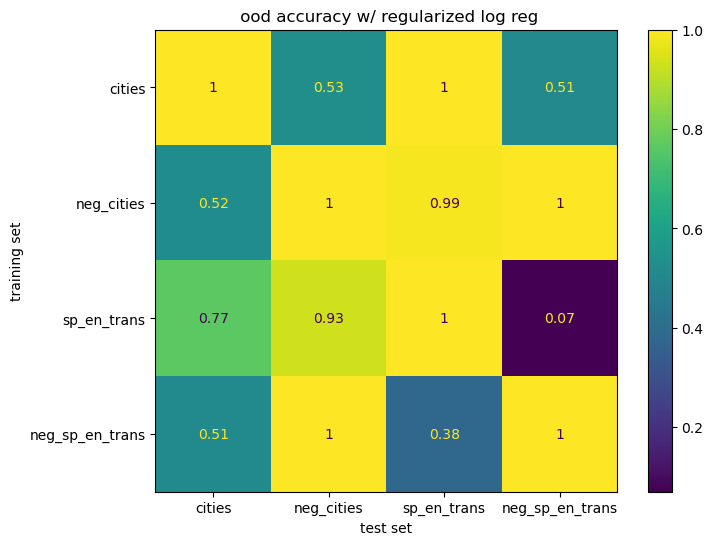

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(8,6))
cm = ConfusionMatrixDisplay(np.reshape(scores, (4,4)), display_labels = dataset_names)

cm.plot(ax=ax)
ax.set_xlabel("test set")
ax.set_ylabel("training set")
ax.set_title(" ood accuracy w/ regularized log reg")

We see that regularizing training on the \texttt{cities} dataset improves the out-of-distribution test accuracy, especially in the case of the \texttt{sp\_en\_trans} test set. Overall however the regularized model performs poorer than the unregularized model, for instance training on \texttt{sp\_en\_trans} and testing on \texttt{cities} or \texttt{neg\_sp\_en\_trans} leads to lower accuracy (.91-> .77 and .52 -> 0.07) in the regularized case.

(c)

In [ ]:
training_sets = ["cities", "neg_cities"]
test_sets = ["sp_en_trans", "neg_sp_en_trans"]
# training on (neg-)cities data
dm = DataManager()
# adding both cities set to data
dm.add_dataset(training_sets[0], "Llama3", "8B", "chat", layer=12, split=0.8, center=False,
                device='cpu', path_to_datasets=path_to_datasets, path_to_acts=path_to_acts)
dm.add_dataset(training_sets[1], "Llama3", "8B", "chat", layer=12, split=0.8, center=False,
                device='cpu', path_to_datasets=path_to_datasets, path_to_acts=path_to_acts)

cities_train, labels_train = dm.get('train')
cities_test, labels_test = dm.get('val')


logreg = LogisticRegression(n_jobs=1, C=1e-1, random_state=0)

logreg.fit(cities_train, labels_train)
# verifying city training
print("city score", logreg.score(cities_test, labels_test))


dm = DataManager()
# adding both cities set to data
dm.add_dataset(test_sets[0], "Llama3", "8B", "chat", layer=12, split=0.8, center=False,
                device='cpu', path_to_datasets=path_to_datasets, path_to_acts=path_to_acts)
dm.add_dataset(test_sets[1], "Llama3", "8B", "chat", layer=12, split=0.8, center=False,
                device='cpu', path_to_datasets=path_to_datasets, path_to_acts=path_to_acts)

trans_test, trans_labels_test = dm.get('val')
print("trans score", logreg.score(trans_test, trans_labels_test))

city score 0.9983333333333333
trans score 0.9859154929577465


Training on both of the cities datasets shows a very high (<0.98) test score for both the cities and the trans test sets.

## 3 Log-sum-exp and soft(arg)max
### (a)

(i) : 
\begin{align}
\text{softmax}(a \sigma, b \lambda)_k &= \frac{\exp(ab \lambda \sigma_k)}{\sum_{i=1}^{n} \exp( ab\sigma_i \lambda)} \\
&= \frac{\left(\exp(\lambda \sigma_k)\right)^{ab}}{\sum_{i=1}^{n} \left(\exp(\sigma_i \lambda)\right)^{ab}} \\
&\neq \frac{\exp(\lambda \sigma_k)}{\sum_{i=1}^{n} \exp(\sigma_i \lambda)}
\end{align}


The function is not invariant under rescaling.

(ii) :
\begin{align}
\text{softmax}(a \sigma, b \lambda)_k &= \frac{\exp( \lambda \sigma_k + c)}{\sum_{i=1}^{n} \exp( ab\sigma_i \lambda +c)} \\
&= \frac{\exp(c)\exp(\lambda \sigma_k)}{\sum_{i=1}^{n} \exp(c)\exp(\sigma_i \lambda)} \\
&= \frac{\exp(c)\exp(\lambda \sigma_k)}{\exp(c)\sum_{i=1}^{n} \exp(\sigma_i \lambda)} \\
&= \frac{\exp(\lambda \sigma_k)}{\sum_{i=1}^{n} \exp(\sigma_i \lambda)}
\end{align}

So the function is invariant under a constant offset. Therefore $\sigma¹$ and $\sigma²$ produce the same result while $\sigma³$ is diffrent.

### (b)

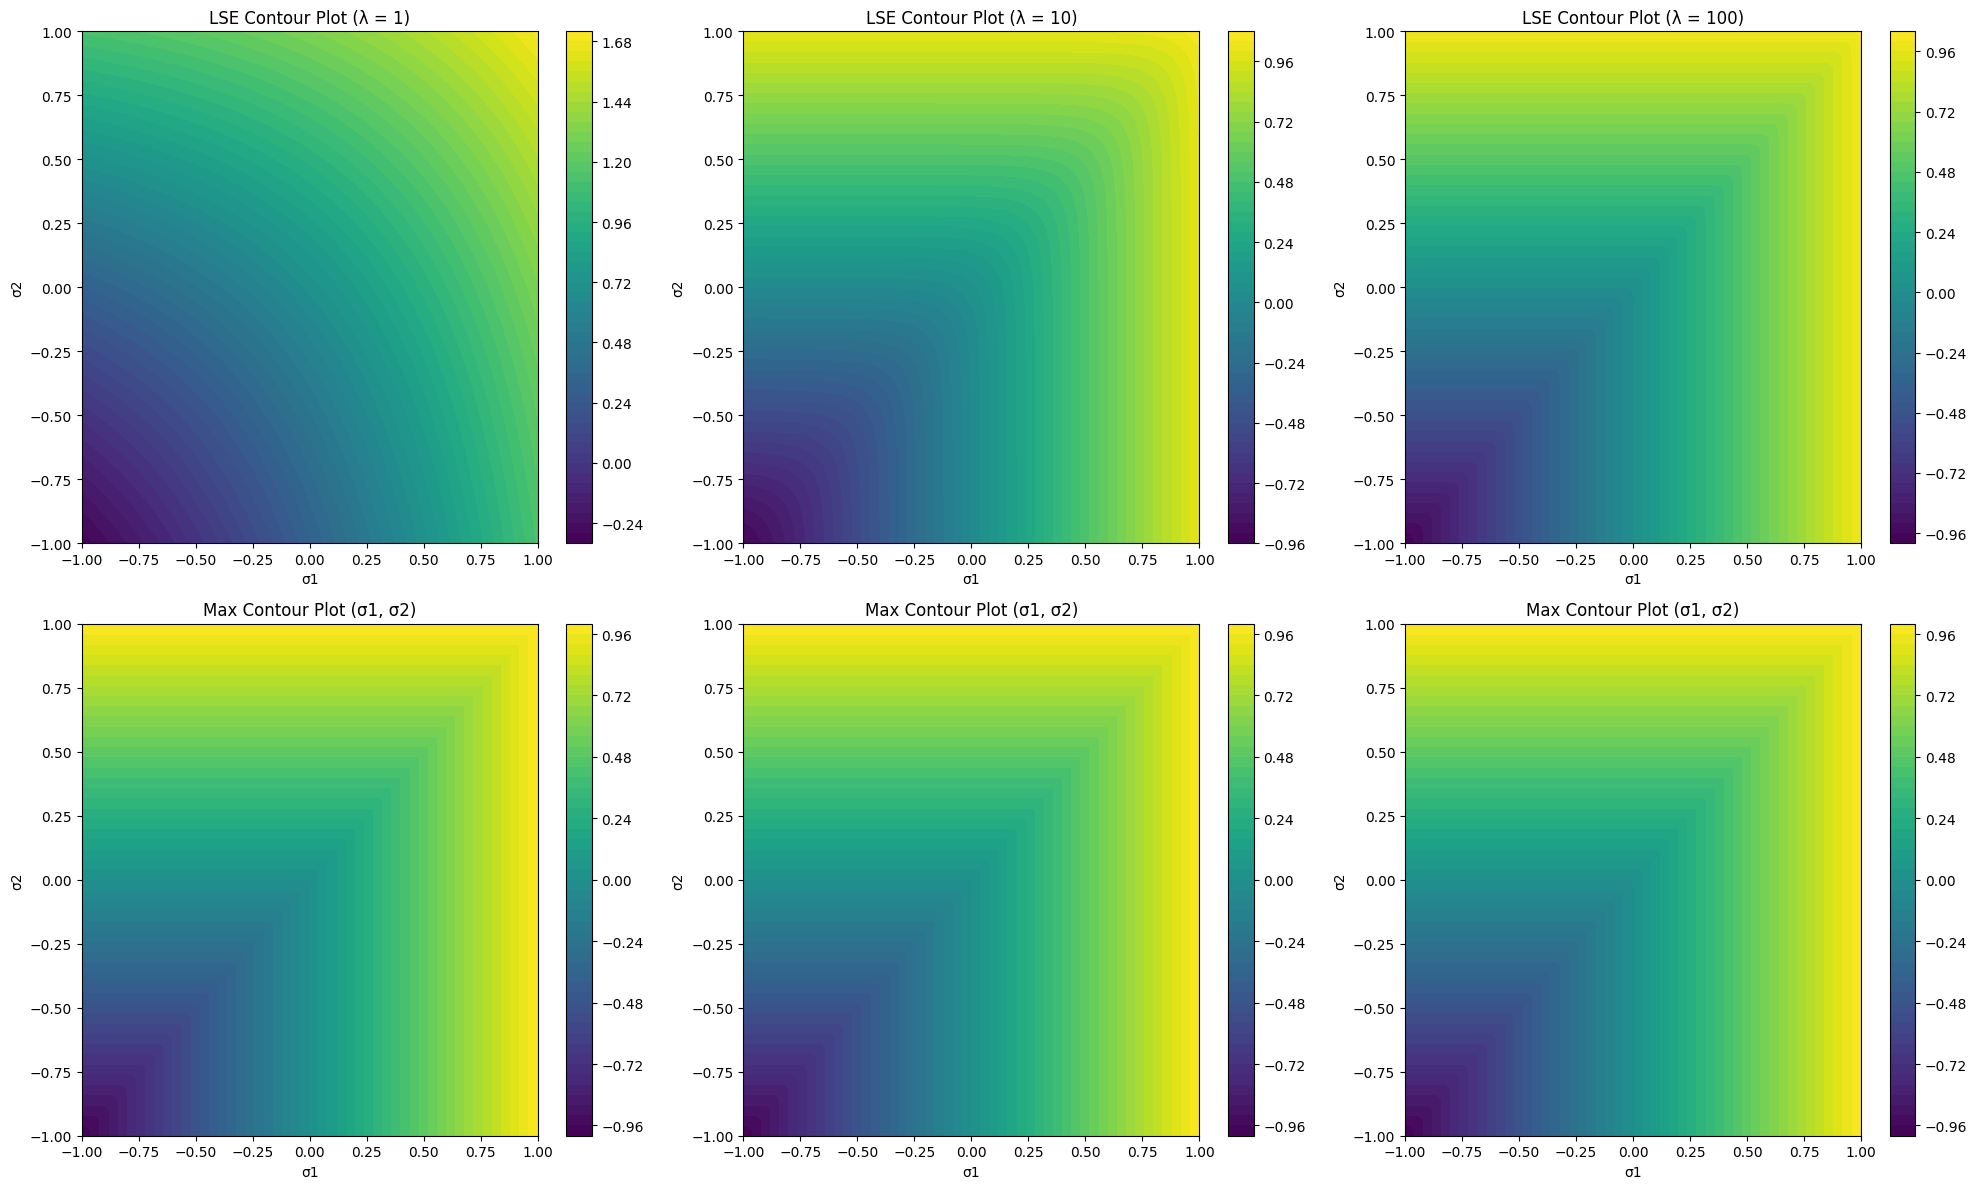

In [ ]:
def lse(sigma, lamda):
    return (1 / lamda) * np.log(np.sum(np.exp(np.array(sigma) * lamda)))


lambda_values = np.array([1, 10, 100])
sigma_values = np.linspace(-1, 1, 100)
sigma_1, sigma_2 = np.meshgrid(sigma_values, sigma_values)


def evaluate_lse(lamda):
    Z = np.zeros_like(sigma_1)
    for i in range(sigma_1.shape[0]):
        for j in range(sigma_1.shape[1]):
            Z[i, j] = lse([sigma_1[i, j], sigma_2[i, j]], lamda)
    return Z


def max_sigma(sigma_1, sigma_2):
    return np.maximum(sigma_1, sigma_2)


fig, axes = plt.subplots(2, len(lambda_values), figsize=(20, 12))


for idx, lam in enumerate(lambda_values):
    Z_lse = evaluate_lse(lam)
    ax = axes[0, idx]
    cp = ax.contourf(sigma_1, sigma_2, Z_lse, levels=50, cmap='viridis')
    fig.colorbar(cp, ax=ax)
    ax.set_title(f"LSE Contour Plot (λ = {lam})")
    ax.set_xlabel("σ1")
    ax.set_ylabel("σ2")


Z_max = max_sigma(sigma_1, sigma_2)
for idx in range(len(lambda_values)):
    ax = axes[1, idx]
    cp = ax.contourf(sigma_1, sigma_2, Z_max, levels=50, cmap='viridis')
    fig.colorbar(cp, ax=ax)
    ax.set_title(f"Max Contour Plot (σ1, σ2)")
    ax.set_xlabel("σ1")
    ax.set_ylabel("σ2")

plt.tight_layout()
plt.show()

### (c)

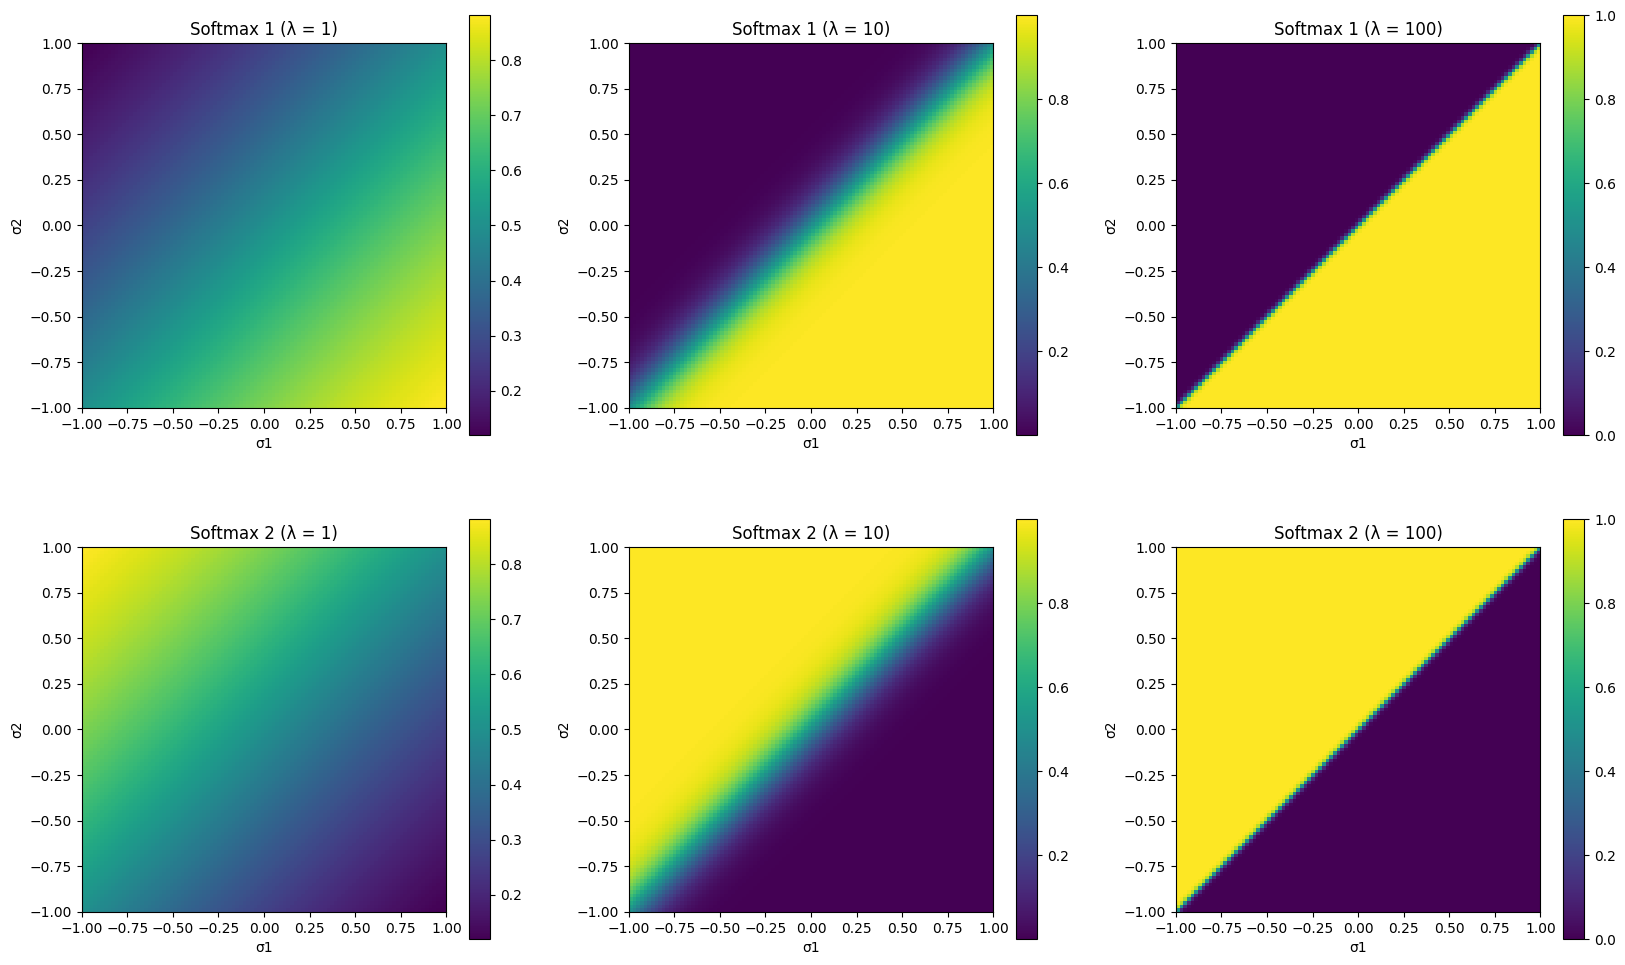

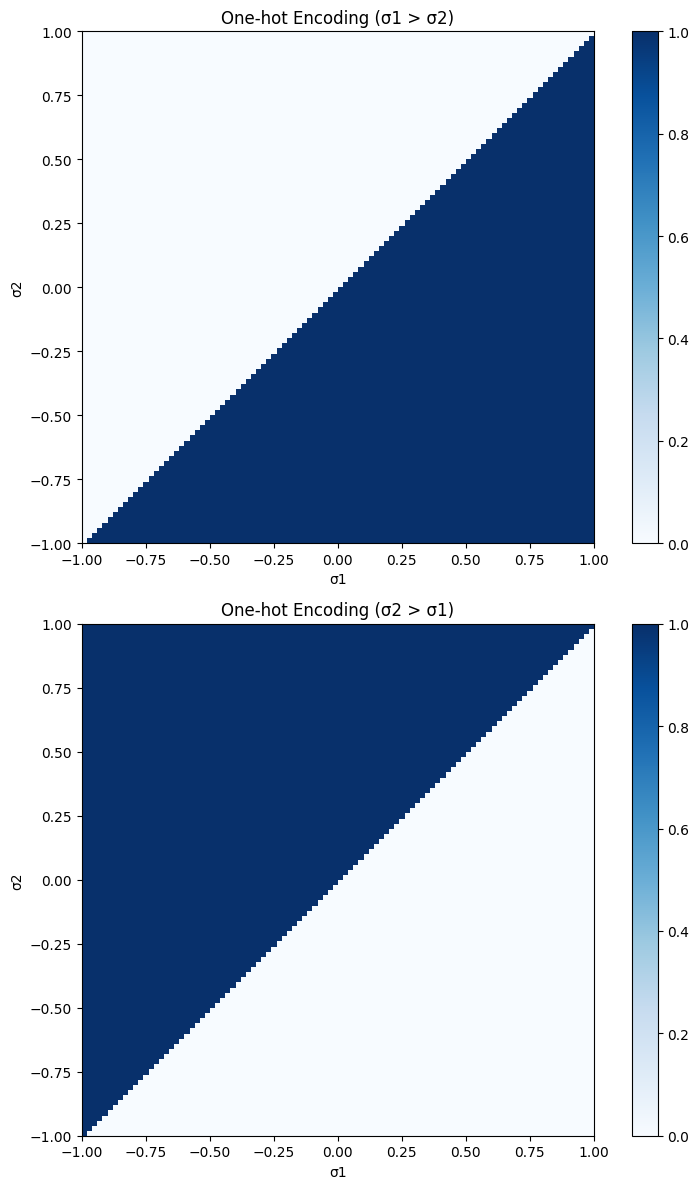

In [14]:
def softmax_1(sigma, lamda):
    return np.exp(sigma[0] * lamda) / (np.exp(sigma[0] * lamda) + np.exp(sigma[1] * lamda))

def softmax_2(sigma, lamda):
    return np.exp(sigma[1] * lamda) / (np.exp(sigma[0] * lamda) + np.exp(sigma[1] * lamda))


def onehot_argmax(sigma):
    return np.array([1, 0] if sigma[0] > sigma[1] else [0, 1])

def evaluate_softmax_components(lamda):
    softmax_1_vals = np.zeros_like(sigma_1)
    softmax_2_vals = np.zeros_like(sigma_1)
    
    for i in range(sigma_1.shape[0]):
        for j in range(sigma_1.shape[1]):
            softmax_1_vals[i, j] = softmax_1([sigma_1[i, j], sigma_2[i, j]], lamda)
            softmax_2_vals[i, j] = softmax_2([sigma_1[i, j], sigma_2[i, j]], lamda)
    
    return softmax_1_vals, softmax_2_vals

def evaluate_onehot():
    onehot_vals_1 = np.zeros((sigma_1.shape[0], sigma_1.shape[1]))
    onehot_vals_2 = np.zeros_like(onehot_vals_1)
    
    for i in range(sigma_1.shape[0]):
        for j in range(sigma_1.shape[1]):
            onehot_vec = onehot_argmax([sigma_1[i, j], sigma_2[i, j]])
            onehot_vals_1[i, j] = onehot_vec[0]
            onehot_vals_2[i, j] = onehot_vec[1]
    
    return onehot_vals_1, onehot_vals_2

fig, axes = plt.subplots(2, len(lambda_values), figsize=(20, 12))

for idx, lam in enumerate(lambda_values):
    softmax_1_vals, softmax_2_vals = evaluate_softmax_components(lam)
    
    ax1 = axes[0, idx]
    im1 = ax1.imshow(softmax_1_vals, extent=[-1, 1, -1, 1], origin='lower', cmap='viridis')
    fig.colorbar(im1, ax=ax1)
    ax1.set_title(f"Softmax 1 (λ = {lam})")
    ax1.set_xlabel("σ1")
    ax1.set_ylabel("σ2")
    
    ax2 = axes[1, idx]
    im2 = ax2.imshow(softmax_2_vals, extent=[-1, 1, -1, 1], origin='lower', cmap='viridis')
    fig.colorbar(im2, ax=ax2)
    ax2.set_title(f"Softmax 2 (λ = {lam})")
    ax2.set_xlabel("σ1")
    ax2.set_ylabel("σ2")

onehot_vals_1, onehot_vals_2 = evaluate_onehot()

fig2, axes2 = plt.subplots(2, 1, figsize=(8, 12))

ax1 = axes2[0]
im1 = ax1.imshow(onehot_vals_1, extent=[-1, 1, -1, 1], origin='lower', cmap='Blues', vmin=0, vmax=1)
fig2.colorbar(im1, ax=ax1)
ax1.set_title("One-hot Encoding (σ1 > σ2)")
ax1.set_xlabel("σ1")
ax1.set_ylabel("σ2")

ax2 = axes2[1]
im2 = ax2.imshow(onehot_vals_2, extent=[-1, 1, -1, 1], origin='lower', cmap='Blues', vmin=0, vmax=1)
fig2.colorbar(im2, ax=ax2)
ax2.set_title("One-hot Encoding (σ2 > σ1)")
ax2.set_xlabel("σ1")
ax2.set_ylabel("σ2")

plt.tight_layout()
plt.show()

### (d)

\begin{align}
\frac{d\text{LSE}(\sigma_k, \lambda)}{d \sigma_k} &= \frac{d}{d\sigma_k}\left(\frac{1}{\lambda} \log\left( \sum_{i=1}^{n} \exp(\sigma_i \lambda) \right)\right) \\
&= \frac{1}{\lambda} \frac{1}{\sum_{i=1}^{n} \exp(\sigma_i \lambda)} \exp(\lambda \sigma_j \delta_{jk}) \lambda \\
&= \frac{\exp(\lambda \sigma_k)}{\sum_{i=1}^{n} \exp(\sigma_i \lambda)} \\
&= \text{softmax}_2(\sigma, \lambda)
\end{align}


## 4 Linear regions of MLPs

(a)

In [ ]:
import torch

from torch.nn import ReLU, Linear

In [ ]:
def shallow_model(x):
    x = x.astype("float32")
    x = x.T
    #assert np.shape(x)[0] == 2
    # initializing the input linear layer that broadcasts all the input to all the hidden units
    torch.manual_seed(0)
    input_layer = Linear(in_features=2, out_features=20)

    # initialize activation function 

    sigma = ReLU()
    
    # initializing the linear layer taht sums the activations into a scalar 
    output_layer = Linear(in_features=20, out_features=1)
    
    # input vector
    #x = np.random.normal(size=(10,2)).astype("float32")
    
    # input vector as tensor
    input_as_tensor = torch.from_numpy(x)
    
    # apply the ReLU after applying linear transformation to the input 
    activation = sigma(linear_layer(input_as_tensor))
    
    # summing the activations to a scalar
    y = output_layer(activation)

    return y

The model has 2 * 20 ($\boldsymbol{w}$) + 20 ($\boldsymbol{b}$) parameters on the input side and 1*20 + 1 parameters on the output. That makes a total of 81 parameters. It should be noted that only the linear layers have parameters and the ReLU has no parameter. Any scaling of the activation fct. would be absorbed into the data itself or explicit scaling layers.

(b), (c)

In [ ]:
def plot_model_output(scale=10, model = shallow_model, title = ""):
    n_points = 2000
    scale = scale
    arr = np.mgrid[-n_points//2:n_points//2, -n_points//2:n_points//2] * (scale*2/n_points)
    # print("arr.shape = ", arr.shape)
    y = model(arr).detach().numpy()
    # remove scalar dimension
    y = np.squeeze(y)
    # print("output shape= ", y.shape)
    extent = (-scale, scale, -scale, scale)
    fig, (ax0, ax1, ax2) = plt.subplots(1,3, figsize=(10,6), sharey = True)
    
    ax0.imshow(y, cmap="gray", extent = extent, origin="lower")
    ax1.imshow(np.gradient(y, axis=1), cmap="prism", extent = extent, origin="lower")
    ax2.imshow(np.gradient(y, axis=0), cmap="prism", extent = extent, origin="lower")

    ax0.set_ylabel("coordinate1")
    ax0.set_xlabel("coordinate0")
    ax1.set_xlabel("coordinate0")
    ax2.set_xlabel("coordinate0")
    ax0.set_title("activation")
    ax1.set_title("deriv. w.r.t. coord. 0")
    ax2.set_title("deriv. w.r.t. coord. 1")
    if title:
        ax1.set_title(title+"\n"+str(ax1.title.get_text()))

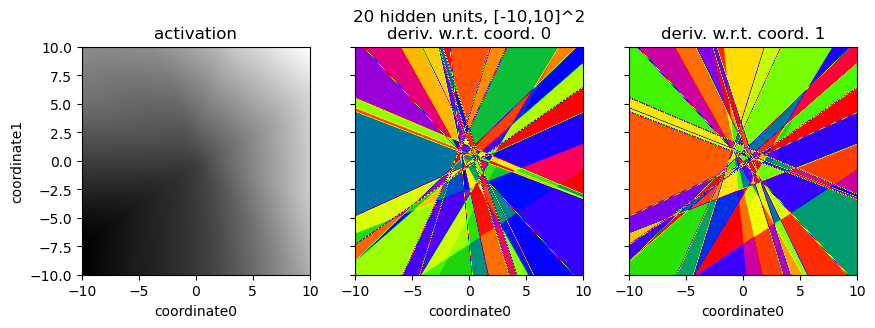

In [ ]:
plot_model_output(title="20 hidden units, [-10,10]^2")

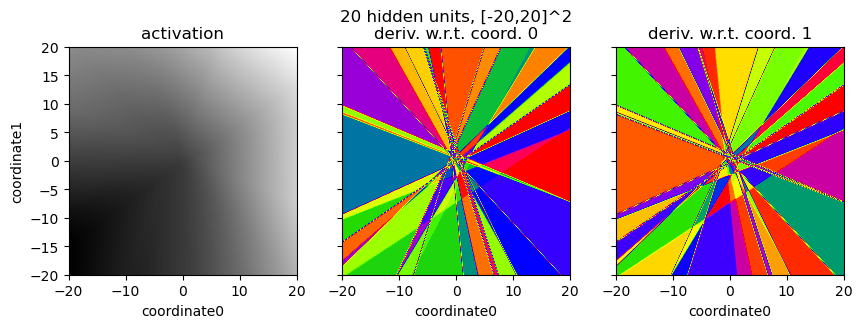

In [ ]:
plot_model_output(scale=20, title="20 hidden units, [-20,20]^2")

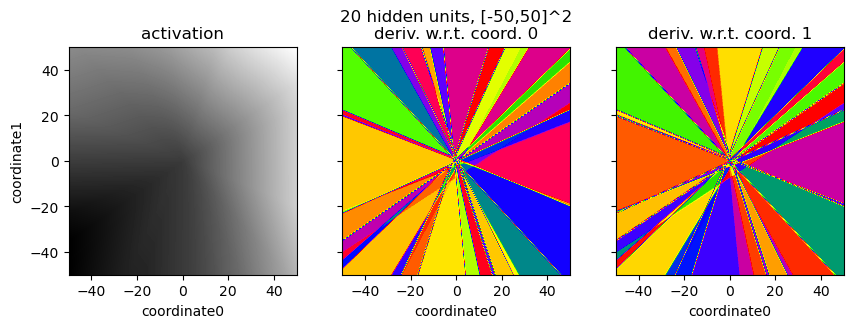

In [ ]:
plot_model_output(scale=50, title="20 hidden units, [-50,50]^2")

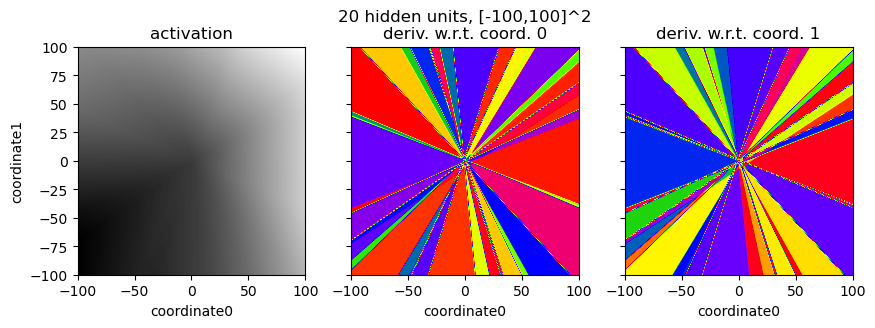

In [ ]:
plot_model_output(scale=100, title="20 hidden units, [-100,100]^2")

We conclude that the structure disappears at $[-100, 100]^2$ and is mostly centered around the origin within $[-5,5]^2$, judging from the derivatives. 

(d)

In [ ]:
def deep_model(x):
    
    x = x.astype("float32")
    x = x.T
    # input vector as tensor
    input_as_tensor = torch.from_numpy(x)
    
    # initialize activation function 
    relu = ReLU()
    
    torch.manual_seed(2)
    # initializing the input linear layer that broadcasts all the input to all the hidden units    
    input_layer = Linear(in_features=2, out_features=5)

    # deep layers
    second_layer = Linear(in_features=5, out_features=5)
    third_layer = Linear(in_features=5, out_features=5)
    fourth_layer = Linear(in_features=5, out_features=5)
    
    # initializing the linear layer taht sums the activations into a scalar 
    output_layer = Linear(in_features=5, out_features=1)
    
    # chaining 
    y = output_layer(
            relu(
                fourth_layer(
                    relu(
                        third_layer(
                            relu(
                                second_layer(
                                    relu(
                                        input_layer(input_as_tensor)
                                    )
                                )
                            )
                        )
                    )
                )
            )
        )

    return y

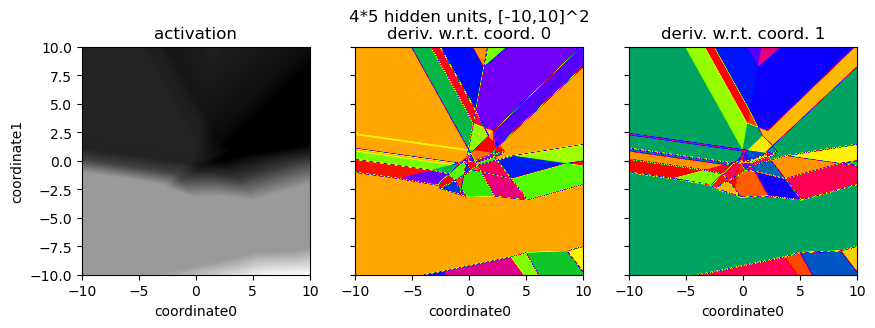

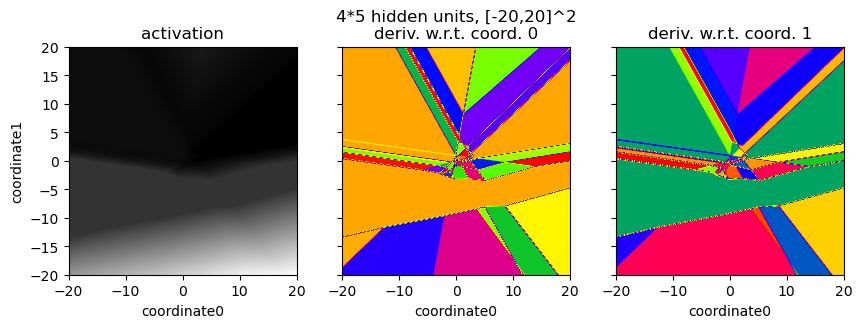

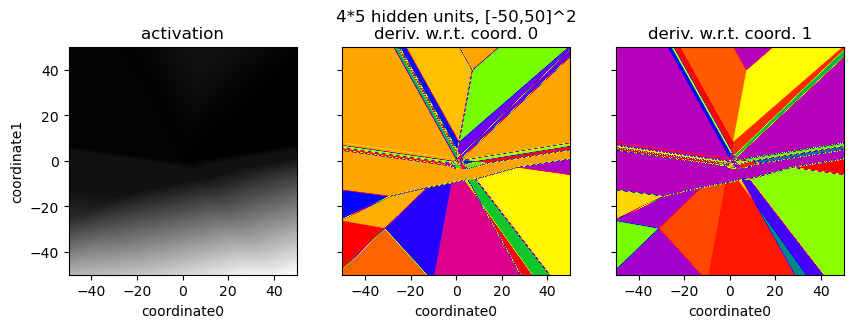

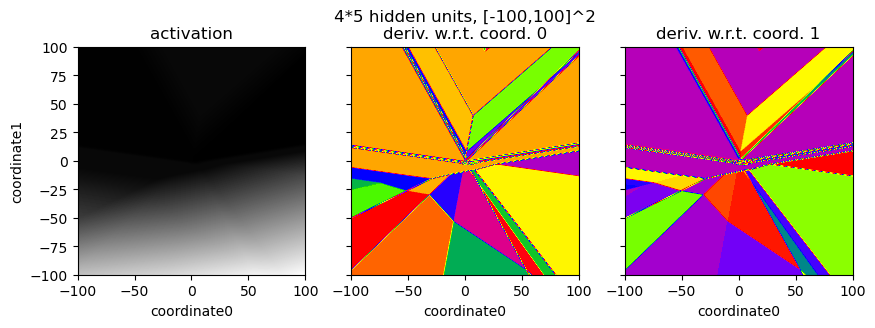

In [ ]:
plot_model_output(scale=10, model=deep_model, title="4*5 hidden units, [-10,10]^2")
plot_model_output(scale=20, model=deep_model, title="4*5 hidden units, [-20,20]^2")
plot_model_output(scale=50, model=deep_model, title="4*5 hidden units, [-50,50]^2")
plot_model_output(scale=100, model=deep_model, title="4*5 hidden units, [-100,100]^2")

For the deeper model with 4 hidden layers (the non-linear activation fct. is applied four times, hence four hidden layers, even though there is a fifth linear layer to the output), the shapes in the output appear more sophisticated judging from the derivatives. It seems like the model activation resembles curved shapes in some instances which is unseen in the linear model, though it is hard to tell with N =1 since the weights are initialized randomly. The structure also does not disappears at larger ranges and as opposed to the shallow model.